# Language Detection Model

### Importing packages

In [26]:
import pandas as pd
import numpy as np
import string
import re
import codecs
import pickle
import time
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

In [27]:
import warnings
%matplotlib notebook
warnings.filterwarnings('ignore')

### Reading csv file

In [28]:
languageDetectionDataset = pd.read_csv('dataset.csv')

### Displaying dataset 

In [29]:
languageDetectionDataset.head()

,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


### Dataset shape

In [30]:
languageDetectionDataset.shape

(22000, 2)

### Discovering Languages to be classified

In [31]:
languages = languageDetectionDataset['language'].unique()
languages

array(['Estonian', 'Swedish', 'Thai', 'Tamil', 'Dutch', 'Japanese',
       'Turkish', 'Latin', 'Urdu', 'Indonesian', 'Portugese', 'French',
       'Chinese', 'Korean', 'Hindi', 'Spanish', 'Pushto', 'Persian',
       'Romanian', 'Russian', 'English', 'Arabic'], dtype=object)

### Adding numeric label for each language

In [32]:
keys = [i for i in range(0,22,1)]
languageLabels = {languages[key]: key for key in keys}
languageLabels

{'Estonian': 0,
 'Swedish': 1,
 'Thai': 2,
 'Tamil': 3,
 'Dutch': 4,
 'Japanese': 5,
 'Turkish': 6,
 'Latin': 7,
 'Urdu': 8,
 'Indonesian': 9,
 'Portugese': 10,
 'French': 11,
 'Chinese': 12,
 'Korean': 13,
 'Hindi': 14,
 'Spanish': 15,
 'Pushto': 16,
 'Persian': 17,
 'Romanian': 18,
 'Russian': 19,
 'English': 20,
 'Arabic': 21}

In [33]:
languageDetectionDataset.groupby('language').count()

,Text
language,
Arabic,1000
Chinese,1000
Dutch,1000
English,1000
Estonian,1000
French,1000
Hindi,1000
Indonesian,1000
Japanese,1000


In [34]:
languageDetectionDataset['Label'] = languageDetectionDataset['language'].apply(lambda x: languageLabels[x])

# 1. Pre-Processing Language Detection Dataset

## 1.1 Checking for duplicates

In [35]:
languageDetectionDataset.duplicated(subset = "Text").any()

True

In [36]:
texts = languageDetectionDataset["Text"]
languageDetectionDataset[texts.isin(texts[texts.duplicated()])].sort_values('Text')

,Text,language,Label
12915,ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...,Hindi,14
6404,ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...,Hindi,14
1846,ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...,Hindi,14
13141,ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...,Hindi,14
7244,ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...,Hindi,14
7200,ईसा पूर्व ईसा मसीह के जन्म से पूर्व के वर्षों...,Hindi,14
12330,- tetracyclines - pencillines cltetracycline a...,Pushto,16
15588,- tetracyclines - pencillines cltetracycline a...,Pushto,16
440,aastakümned aastad aastad aastad aastad a...,Estonian,0
6421,aastakümned aastad aastad aastad aastad a...,Estonian,0


In [37]:
languageDetectionUniqueDataset = languageDetectionDataset.drop_duplicates(subset ="Text")
languageDetectionUniqueDataset.duplicated(subset = "Text").any()

False

## 1.2 Checking for missing values

In [38]:
languageDetectionUniqueDataset.isnull().sum()

Text        0
language    0
Label       0
dtype: int64

## 1.3 Checking the type of letters of each language

In [39]:
languageDetectionUniqueDataset[languageDetectionUniqueDataset['language'] == 'Pushto'].head(20)

,Text,language,Label
27,لویي په کالونیو کې د ظلم کولو خلاف وو او له خل...,Pushto,16
47,ـــ په رجب هـ ق كال دوانت وايگل ولسوالي دجمچ...,Pushto,16
73,د ننۍ نړۍ واقعيتونه دا دي چې د نړيوال کيدنې پر...,Pushto,16
75,که يو ليکوال په خپل کتاب کې خپل يا پردي نوي جو...,Pushto,16
89,شیبه راډیو خپلو اورېدونکو ته سم معلومات دقیق ا...,Pushto,16
98,نن ټکی اسیا په خپل کاري مجال کې وتوانېدل چې په...,Pushto,16
121,د ایزو هغه گڼه چی په کی په چاپ ورسیده پدی ځا...,Pushto,16
185,کوشانيان د مسيح تر زېږېدو کاله د مخه ځينی قبي...,Pushto,16
210,علامه سېد د خپلو افکارو نظرياتو څېړنې او تبليغ...,Pushto,16
215,single periodic block يواځينی دوراني بلاک پدې ...,Pushto,16


## 1.4 Grouping languages into 2 classes

In [40]:
latinAlphabeticLanguages = ['Estonian', 'Swedish', 'Dutch', 'Turkish', 'Latin', 'Indonesian', 'Portugese', 'French', 'Spanish', 'Romanian', 'Russian', 'English']
nonLatinAlphabeticLanguages = ['Thai', 'Tamil', 'Japanese', 'Urdu', 'Chinese', 'Korean', 'Hindi', 'Pushto', 'Persian', 'Arabic']

In [41]:
languageDetectionUniqueDataset.shape

(21859, 3)

In [42]:
latinAlphabeticLanguagesRows = languageDetectionUniqueDataset.language.apply(lambda x : x in latinAlphabeticLanguages)
nonLatinAlphabeticLanguagesRows = languageDetectionUniqueDataset.language.apply(lambda x : x in nonLatinAlphabeticLanguages)

latinAlphabeticLanguagesDataset = languageDetectionUniqueDataset[latinAlphabeticLanguagesRows]
nonLatinAlphabeticLanguagesdataset = languageDetectionUniqueDataset[nonLatinAlphabeticLanguagesRows]

## 1.5 Converting each character into lowercase and removing punctuations and digits

In [43]:
#Punctuations to be removed
for char in string.punctuation:
    print(char, end = " ")
punctuation = [char for char in string.punctuation]
# Adding Arabic digits
punctuation.extend(['١', '٢', '٣', '٤', '٥', '٦', '٧', '٨', '٩', '٠']) 

! " # $ % & ' ( ) * + , - . / : ; < = > ? @ [ \ ] ^ _ ` { | } ~ 

### 1.5.1 Cleaning Latin Alphabetic Languages Dataset (languages with letters such as a,b,c, etc...)

In [44]:
def cleaningLatinAlphabeticLanguagesDataset(text):
    text = text.lower() # lowercase letters
    text = ''.join([i for i in text if i not in string.punctuation]) # Punctuation
    text = re.sub('\d+', '', text) # Digits
    return text
latinAlphabeticLanguagesDataset['Text'] = latinAlphabeticLanguagesDataset['Text'].apply(cleaningLatinAlphabeticLanguagesDataset)

### 1.5.2 Cleaning Non Latin Alphabetic Languages dataset

In [45]:
def cleaningNonLatinAlphabeticLanguagesDataset(text):
    text = text.lower() # lowercase letters
    text = ''.join([i for i in text if i not in string.punctuation]) # Punctuation
    text = re.sub(r'\d+', '', text) # Digit
    text = re.sub(r'[a-zA-Z]+', '', text) # Latin letters
    return text
nonLatinAlphabeticLanguagesdataset['Text'] = nonLatinAlphabeticLanguagesdataset['Text'].apply(cleaningNonLatinAlphabeticLanguagesDataset)

## 1.6 Appending 2 Dataframes

In [46]:
preprocessedLanguageDetectionDataset = latinAlphabeticLanguagesDataset.append(nonLatinAlphabeticLanguagesdataset, ignore_index=True)

# 2 Building the Model

## 2.1 Splitting Dataset

In [47]:
X, y = preprocessedLanguageDetectionDataset.iloc[:]['Text'].values, preprocessedLanguageDetectionDataset.iloc[:]['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 12)

In [48]:
# implementing accuracy method
def calculateAccuracy(yTest, yPredicted):
    counter = 0
    for k in range(len(yPredicted)):
        if yPredicted[k] == yTest[k]:
            counter += 1
    return (counter/len(yPredicted))*100

## 2.2 Implementing Multinomial Naive Bayes

In [51]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range = (1,3), analyzer = 'char')
piplineNB = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', MultinomialNB())
])
piplineNB.fit(X_train, y_train)
NBTrainPrediction = piplineNB.predict(X_train)
NBTestPrediction = piplineNB.predict(X_test)
print("Training Set Accuracy: ", calculateAccuracy(y_train, NBTrainPrediction))
print("Test Set Accuracy: ", calculateAccuracy(y_test, NBTestPrediction))

Training Set Accuracy:  98.1822618030987
Test Set Accuracy:  97.71271729185727


## 2.3 Implementing Support Vector Machine (SVM)

In [52]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range = (1,3), analyzer = 'char')
piplineSVM = pipeline.Pipeline([
    ('vectorizer', vectorizer),
    ('clf', SVC(kernel='linear'))
])
piplineSVM.fit(X_train, y_train)
SVMTrainPrediction = piplineSVM.predict(X_train)
SVMTestPrediction = piplineSVM.predict(X_test)
print("Training Set Accuracy: ", calculateAccuracy(y_train, SVMTrainPrediction))
print("Training Set Accuracy: ", calculateAccuracy(y_test, SVMTestPrediction))

Training Set Accuracy:  99.26802488715384
Training Set Accuracy:  98.37145471180237


## 2.4 Comparing the Accuracy of NB and SVM using Cross Validation 

In [53]:
#NB
yPredictedNB = cross_val_predict(piplineNB, X, y, cv = 6)
calculateAccuracy(y, yPredictedNB)

98.0374216569834

In [54]:
#SVM
yPredictedSVM = cross_val_predict(piplineSVM, X, y, cv = 6)
calculateAccuracy(y, yPredictedSVM)

98.69161443798893

## 2.5 Comparing run time of the two classifiers to train the model

In [55]:
startTime = time.time()
piplineNB.fit(X_train, y_train)
print(" %s seconds" % (time.time() - startTime))

 11.693796157836914 seconds


In [56]:
startTime = time.time()
piplineSVM.fit(X_train, y_train)
print(" %s seconds" % (time.time() - startTime))

 80.32958006858826 seconds


### NB is faster than SVM by almost 69 seconds adn lower cross validation accuracy by 0.7%. Overall the two classifiers are performing the same. However, NB is much faster therefore it will be choosen to build the model. 

## 2.6 Confusion Matrix

<IPython.core.display.Javascript object>


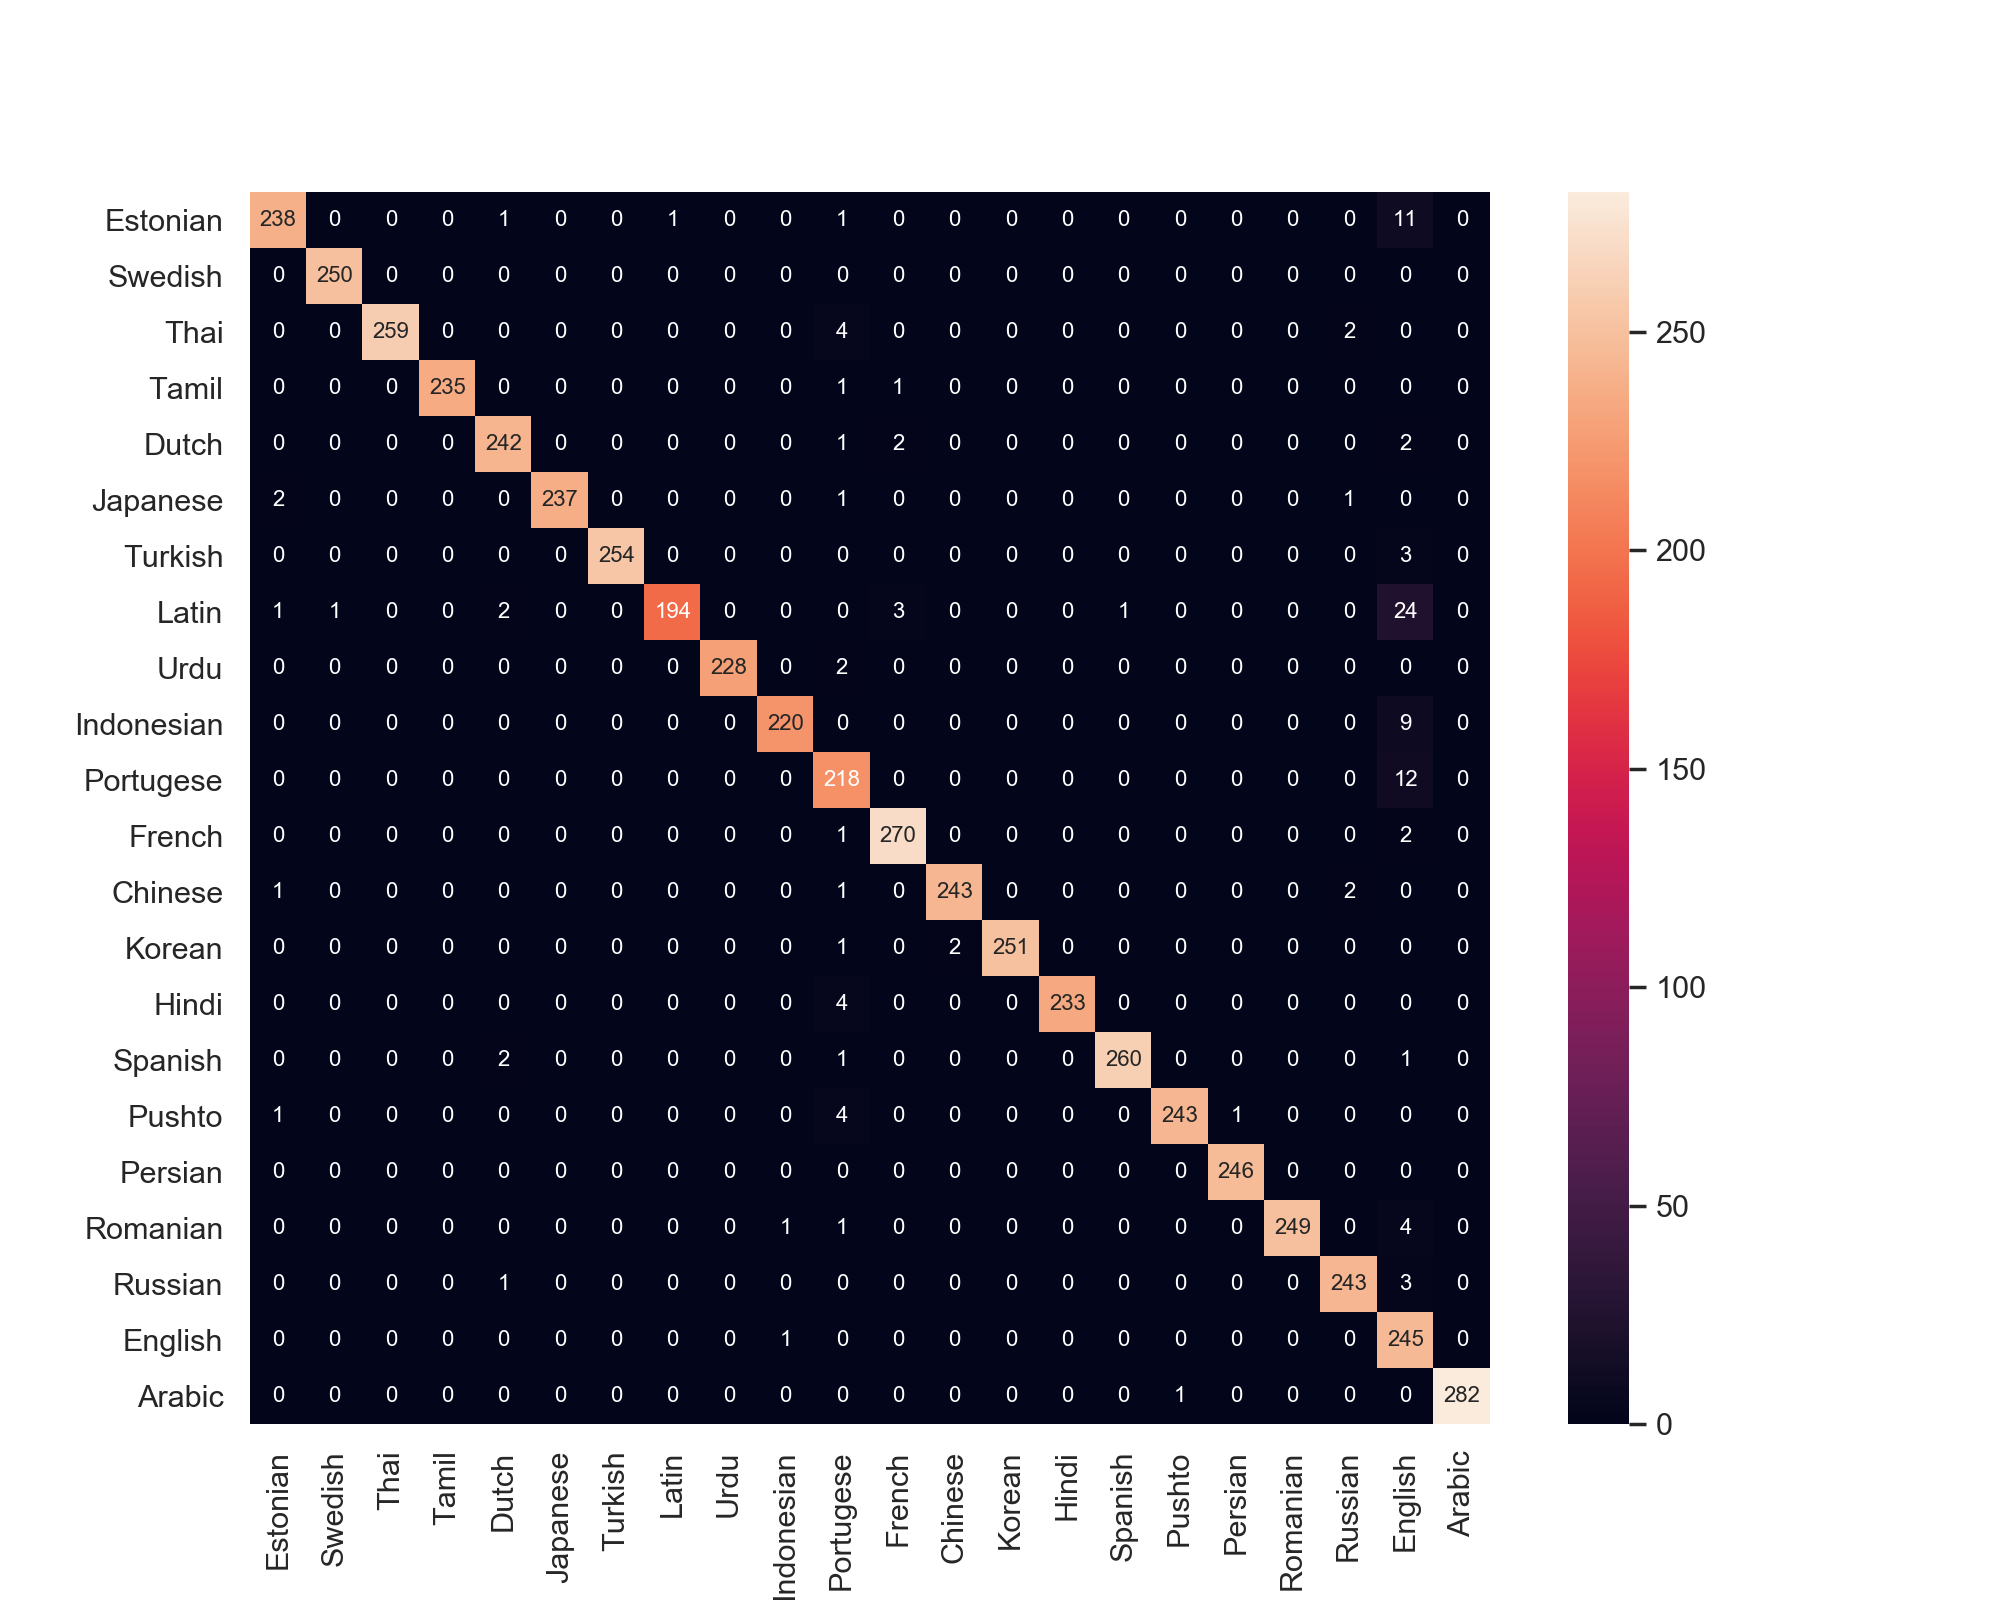

In [58]:
plt.figure(figsize = (10,8))
confusionMatrix = metrics.confusion_matrix(y_test, NBTestPrediction)
labelDf = pd.DataFrame(confusionMatrix, languages, languages)
sns.set(font_scale=1) # for label size
sns.heatmap(labelDf,xticklabels=True, yticklabels=True, annot=True, cbar=True,fmt='g', annot_kws={"size": 8}) # font size
plt.show()

## 2.7 Saving the model

In [59]:
languageDetectionModelFile = open('LanguageDetectionModel.pcl1', 'wb')
pickle.dump(piplineNB, languageDetectionModelFile)
languageDetectionModelFile.close()

## 2.8 Implementing Detection Method for new Inputs

In [60]:
def predictLanguage(text):
    import numpy as np
    import pandas as pd
    import re
    import pickle
    import string
    text = text.lower() # lowercase letters
    text = ''.join([i for i in text if i not in string.punctuation]) # Punctuation
    text = re.sub('\d+', '', text) # Digits
    global languageDetectionModel
    languageDetectionModelFile = open('LanguageDetectionModel.pcl1', 'rb')
    languageDetectionModel = pickle.load(languageDetectionModelFile)
    languageDetectionModelFile.close()
    prediction = languageDetectionModel.predict([text])
    languageDetectionDataset = pd.read_csv('dataset.csv')
    languages = languageDetectionDataset['language'].unique()
    keys = [i for i in range(0,22,1)]
    languageLabels = {languages[key]: key for key in keys}
    languagePredicted = ''
    for language, label in languageLabels.items():  
        if prediction[0] == label:
            languagePredicted = language
            break
    return languagePredicted

In [69]:
predictLanguage('Est-ce que vous pourriez parler plus lentement vous plaît')

'French'